In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from model.erroneousChoice_full import  erroneousChoice
from kernel import jaxrbf
from utility import  paramz
import matplotlib.pyplot as plt  

# Choosing Cupcakes



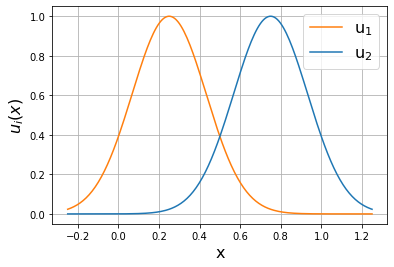

In [3]:
np.random.seed(1)
bounds=[[-0.25,1.25]]
def fun(x,sigma=0):
    u1 = np.exp(-(x-0.25)**2*15)+np.random.randn(len(x),1)*sigma #np.exp(-(x-0.25)**2*15)
    u2 = np.exp(-(x-0.75)**2*15)+np.random.randn(len(x),1)*sigma #np.exp(-(x-0.75)**2*15)
    return np.hstack([u1,u2])
Xpred=np.linspace(bounds[0][0],bounds[0][1],200)[:,None]

output = fun(Xpred,0.0)
plt.plot(Xpred[:,0],output[:,0],color='C1',label="u$_1$")
plt.plot(Xpred[:,0],output[:,1],color='C0',label="u$_2$")
plt.xlabel("x",fontsize=16)
plt.ylabel("$u_i(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
plt.savefig("ChoiceCupcake.pdf")

# Learning from choice data

We illustrate the overall model with an example. We consider the bi-dimensional utility function ${\bf u}(x)=[u_1(x),u_2(x)]$ with $x \in \mathbb{R}$. 
We use ${\bf u}$ to define a choice function via Pareto dominance. For instance, consider the set of options $A_k=\{x_1,x_2,x_3\}$, assume that ${\bf u}(x_1)=[1,0]$, ${\bf u}(x_2)=[0.54,-0.84]$, $
{\bf u}(x_3)=[0,1]$,
we have that $C(A_k)=\{x_1,x_3\}$ and $R(A_k)=A_k \backslash C(A_k)=\{x_2\}$. In fact, one can notice that  $[1,0]$ dominates  $[0.54,-0.84]$ on both the utilities, and $[1,0]$  and $[0,1]$ are incomparable.  We sample $30$ inputs $x_i$ at random in $[-0.25,1.25]$ and, using the above approach, we generate a dataset 
of $m=100$ random subsets $\{A_k\}_{k=1}^m$ of the 30 points each one of size $|A_k|=3$  and computed the corresponding choice pairs $(C(A_k),A_k)$ based on  ${\bf u}$ defined by `fun`.

Note that, we use botorch (and torch) only to build the dataset (in particular we use the function `is_non_dominated`).

In [25]:
import torch
from botorch.utils.multi_objective import is_non_dominated

def is_pareto(X):
    return is_non_dominated(torch.from_numpy(X),deduplicate=False)

#generate CA RA sets
def make_CA_RA(x, y, rows=[],typeR='rational'):
    if len(rows)==0:
        rows=np.arange(x.shape[0])
    if typeR=='rational':
        acc = rows[is_pareto(y)]
        rej = rows[~ is_pareto(y)]
    elif typeR=='pseudo':
        indy = np.unique(np.argmax(y,axis=0))
        acc = rows[indy]
        rej = rows[np.setdiff1d(np.arange(x.shape[0]),indy)]
    return acc, rej

def make_observations(X, fun, nA, dimA,typeR='rational'):
    CA=[]
    RA=[]   
    ix = 0
    for i in range(nA):
        rows = np.random.permutation(np.arange(X.shape[0]))[0:dimA]
        x=X[rows,:]
        y=fun(x)
        acc,rej=make_CA_RA(x, y, rows,typeR=typeR)
        if len(acc)>0:
            CA.append(acc)
        else:
            CA.append([])
        if len(acc)<dimA:
            RA.append(rej)
        else:
            RA.append([])
        ix = ix+1
    return CA, RA


#generate data
np.random.seed(123)

# we randomly generate objects
n = 100 # number of objects
X = (np.vstack(bounds)[:,0]+np.random.rand(n,1)*(np.vstack(bounds)[:,1]-np.vstack(bounds)[:,0]))

# we randomly generate choice data
nA = 200 # number of choice sets
dimA = 3 # dimension of each choice set
CA, RA = make_observations(X, fun, nA, dimA,typeR='pseudo')
CA

[array([19, 61]),
 array([27, 95]),
 array([ 5, 72]),
 array([44,  1]),
 array([32, 73]),
 array([48, 29]),
 array([95]),
 array([82, 67]),
 array([0]),
 array([97,  3]),
 array([23, 54]),
 array([98, 36]),
 array([61, 24]),
 array([ 9, 72]),
 array([83, 81]),
 array([14,  7]),
 array([34, 57]),
 array([63, 70]),
 array([81, 88]),
 array([52, 99]),
 array([99]),
 array([73, 54]),
 array([98, 51]),
 array([21, 92]),
 array([82, 80]),
 array([63,  9]),
 array([46, 79]),
 array([12, 29]),
 array([60, 13]),
 array([14,  4]),
 array([15, 53]),
 array([57]),
 array([ 1, 72]),
 array([52, 39]),
 array([86, 97]),
 array([82, 50]),
 array([ 1, 62]),
 array([73, 30]),
 array([52, 12]),
 array([41, 57]),
 array([90, 88]),
 array([32, 95]),
 array([20,  9]),
 array([51, 12]),
 array([88]),
 array([66, 35]),
 array([71, 96]),
 array([44, 99]),
 array([81, 25]),
 array([12, 60]),
 array([43, 37]),
 array([34, 72]),
 array([40]),
 array([28,  4]),
 array([54, 93]),
 array([89, 11]),
 array([ 4, 88]),

## Fixed latent dimension

The following code allows us to learn a choice function from choice-data. We have to select the latent dimension `latent_dim`, which represents the number of utility functions. Similarly to GP processes for multiclass classification, we model each  latent utility function in the vector ${\bf u}({\bf x})=[u_1({\bf x}),\dots,u_{d}({\bf x})]^\top$ as an independent GP:

$$
 u_i({\bf x}) \sim \text{GP}_i(0,k_i({\bf x},{\bf x}')), ~~~~i=1,2,\dots,d.
$$

 Each GP is fully specified by its kernel function $k_i(\cdot,\cdot)$, which defines the covariance of the latent function between any two points. The model parameters are the kernel parameters (lengthscales) in $k_i(\cdot,\cdot)$, and the variance. These parameters must be initiliased and then they are optimised using variational inference.

In [29]:
#choice data
data={'X': X,#objects
      'CA': CA,#choiced objects
      'RA': RA,#rejected objects
      'dimA':dimA# dimension of the choice set
          }

# number of latent utilities
latent_dim=2

# define kernel 
Kernel = jaxrbf.RBF
#hyperparameters of the kernel
params = {'lengthscale_0': {'value':1.0*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_0': {'value':np.array([10.0]), 
                            'range':np.vstack([[1.0, 100.0]]),
                            'transform': paramz.logexp()},
          'lengthscale_1': {'value':1.0*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_1': {'value':np.array([10.0]), 
                            'range':np.vstack([[1.0, 100.0]]),
                            'transform': paramz.logexp()}
              }



# define choice model 
model = erroneousChoice(data,Kernel,params,latent_dim,typeR="pseudo",jitter=1e-6)
# compute variational inference and estimate hyperparameters
model.optimize_hyperparams(niterations=3000,kernel_hypers_fixed=False, 
                           #init_f=np.zeros(2*X.shape[0]),
                           diagonal=False)
print(model.params)

 lower bound 455.91849464786947: 100%|██████████| 3000/3000 [04:52<00:00, 10.24it/s]

{'lengthscale_0': {'value': array([0.30692761]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7f066c2fbc40>}, 'variance_0': {'value': array([29.86967228]), 'range': array([[  1., 100.]]), 'transform': <utility.paramz.logexp object at 0x7f056c07a880>}, 'lengthscale_1': {'value': array([0.21518932]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7f056c07ab50>}, 'variance_1': {'value': array([28.96496998]), 'range': array([[  1., 100.]]), 'transform': <utility.paramz.logexp object at 0x7f056c07a5e0>}}


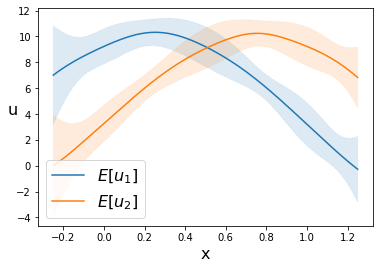

In [30]:
predictions = model.predict_VI(Xpred)

mean=predictions[0]
Sigma=predictions[1]
mean1=mean[0:Xpred.shape[0]]
mean2=mean[Xpred.shape[0]:]
d=np.sqrt(np.diag(Sigma[0:Xpred.shape[0],0:Xpred.shape[0]]))[:,None]
cred_int1=mean1+2*np.hstack([-d,d])
d=np.sqrt(np.diag(Sigma[Xpred.shape[0]:,Xpred.shape[0]:]))[:,None]
cred_int2=mean2+2*np.hstack([-d,d])
plt.plot(Xpred[:,0],mean1,color='C0',label="$E[u_1]$")
plt.plot(Xpred[:,0],mean2,color='C1',label="$E[u_2]$")
plt.fill_between(Xpred[:,0],cred_int1[:,0],cred_int1[:,1],
                 color='C0', linestyle=':',alpha=0.15)

plt.fill_between(Xpred[:,0],cred_int2[:,0],cred_int2[:,1],color='C1', linestyle=':',alpha=0.15)

plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16, rotation=0)
plt.legend(fontsize=16,loc='lower left')
plt.savefig("EstimatedCupcakes_pseudo_pseudo.pdf")

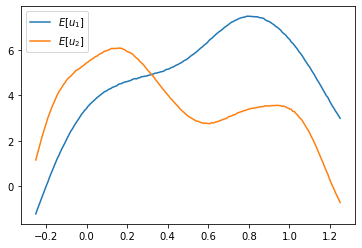

In [28]:
from scipy.stats import multivariate_normal
mean = predictions[0]
Sigma = predictions[1]
#first utility
samples = multivariate_normal(mean[:,0],Sigma+1e-4*np.eye(Sigma.shape[0])).rvs(100)
i =6
u1 = samples[i][0:Xpred.shape[0]]
u2 = samples[i][Xpred.shape[0]:]
plt.plot(Xpred[:,0],u1,color='C0',label="$E[u_1]$")
plt.plot(Xpred[:,0],u2,color='C1',label="$E[u_2]$")
plt.legend()
#plt.savefig("Estimatedcupcakesamples.pdf")

## Learning the latent dimension
To learn the latent dimension, we will use the PSIS-LOO. We will try all values of the latent dimension between 1 and 4 and select the value which has lowest PSIS-LOO.

In [ ]:
import model_selection as ms

Scores=ms.model_Selection(X,dimA,  CA_tr=CA, RA_tr=RA, minm=1,maxm=4)
Scores

The best dimension is $2$, equal to the true dimension.